In [1]:
# Imports

from scipy.io import wavfile
import matplotlib.pyplot as plt
import numpy as np
import tools
import basilarmembrane
from scipy import signal



In [2]:
# Load Data

samplerate, data = wavfile.read('audio.wav')

# Discard single channel as we model only one ear in this case
audio = np.array(data[:, 0], dtype=float)
# Signal length in samples
nt = len(audio)

print("Sample rate of audio data: {}".format(samplerate))
print("Length of signal: {} samples".format(nt))
print("Temporal signal duration: {} seconds ({} minutes and {} seconds)"
      .format(nt/samplerate, int((nt/samplerate)//60), (nt/samplerate)%60))

Sample rate of audio data: 44100
Length of signal: 14538287 samples
Temporal signal duration: 329.6663718820862 seconds (5 minutes and 29.666371882086196 seconds)


In [3]:
#Rescale signal between -1 and 1
audio = tools.rescale(audio, -1, 1)


-32768.0 32099.0


Text(0.5, 1.0, 'Dave Brubeck - Take Five')

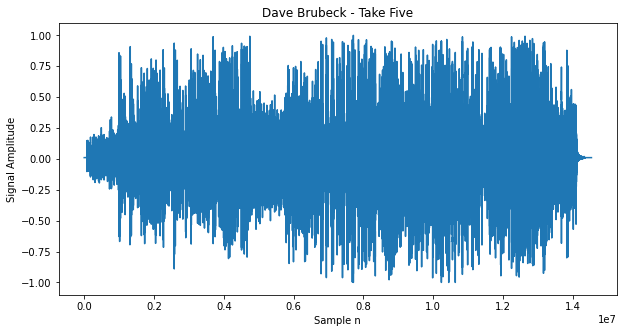

In [4]:
# Plot signal in the time domain
plt.figure(figsize=(10, 5))
plt.plot(audio)
plt.xlabel('Sample n')
plt.ylabel('Signal Amplitude')
plt.title('Dave Brubeck - Take Five')

Text(0, 0.5, 'Magnitude')

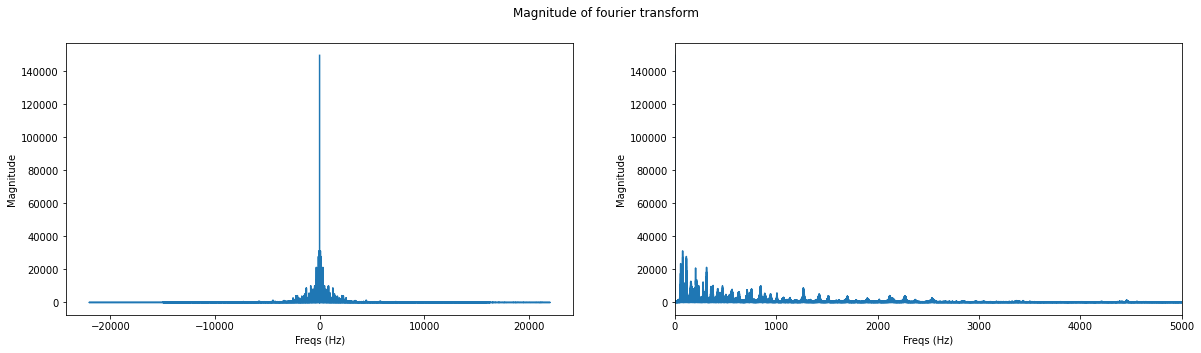

In [5]:
# Plot signal in the fourier domain
audio_fft = np.fft.fft(audio)
audio_fft_freqs = np.fft.fftfreq(nt, 1/samplerate)

plt.figure(figsize=(20, 5))
plt.suptitle('Magnitude of fourier transform')
plt.subplot(1, 2, 1)
plt.plot(audio_fft_freqs, np.abs(audio_fft))
plt.xlabel('Freqs (Hz)')
plt.ylabel('Magnitude')


plt.subplot(1, 2, 2)
plt.plot(audio_fft_freqs, np.abs(audio_fft))
plt.xlim(0, 5000)
plt.xlabel('Freqs (Hz)')
plt.ylabel('Magnitude')

C:\Users\richa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\matplotlib\axes\_axes.py:7626: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


Text(0, 0.5, 'Frequency (hZ)')

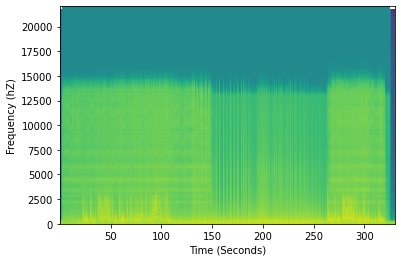

In [6]:
powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(audio, Fs=samplerate)
plt.xlabel('Time (Seconds)')
plt.ylabel('Frequency (hZ)')

 

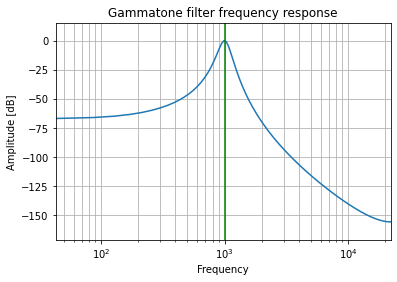

In [19]:
ffilt = 1000
b, a = basilarmembrane.gammatone(ffilt, samplerate)
w, h = signal.freqz(b, a, fs=samplerate)

plt.plot(w, 20 * np.log10(abs(h)))
plt.xscale('log')
plt.title('Gammatone filter frequency response')
plt.xlabel('Frequency')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(ffilt, color='green') # cutoff frequency
plt.show()

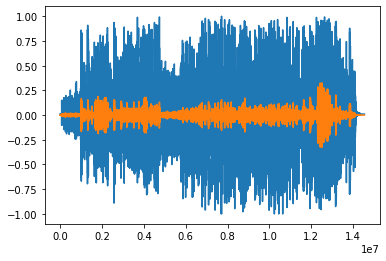

In [22]:
filtered_audio = signal.lfilter(b, a, audio)
plt.figure()
plt.plot(audio)
plt.plot(filtered_audio)